In [0]:
from keras.preprocessing import image
img=image.load_img('Input_resolution.jpg')
x=image.img_to_array(img)
x.shape
import numpy as np
x = np.expand_dims(x, axis=0)
x.shape





In [0]:
import os

In [0]:
os.getcwd()

In [1]:
from google.colab import drive
drive.mount('/sample_data')

Drive already mounted at /sample_data; to attempt to forcibly remount, call drive.mount("/sample_data", force_remount=True).


In [2]:

from os import path
import cv2
import os
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D,Flatten
from keras.layers.core import Dense,Dropout,Activation
from keras.optimizers import adam
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt 


Using TensorFlow backend.


In [0]:
#Reference Book:  [Navin_Kumar_Manaswi]_Deep_Learning_with_Applicati(z-lib.org).pdf


original_data_path='/sample_data'



def load_small_img_dataset(path=os.getcwd()):
    data=[]
    for image in os.listdir(path):
        if image.endswith(('.jpg','.jpeg','.png','bmp'),0,len(image)):
            pixels=cv2.imread(os.path.join(path,image))
            pixels=pixels[0:100,0:90]  #first make all images of same size using crop
            data.append(pixels)
            
    return data
    
imgs=load_small_img_dataset(original_data_path)
            
# OR import keras dataset       from keras.datasets import cifar10  
#(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')





#generate a random number between 0 and 1 and if it is less than 0.7 than the current image is in train set else fi >0.9 then test else dev set

#or use sklearn.model_selection import train_test_split

def test_train_dev_split(dataset,train=0.7,dev=0.2,test=0.1):
    #make seed for exact results everything
    #random.sort(dataset)
    random.seed(2)
    random.shuffle(dataset)
    split1=int(train*len(dataset))
    split2=int((train+dev)*len(dataset))
    
    train_set=dataset[:split1]
    dev_set=dataset[split1:split2]
    test_set=dataset[split2:]
    
    return train_set,dev_set,test_set
    
    
def create_input_out_sets(train_output,dev_output,test_output):
    train_input=[]
    dev_input=[]
    test_input=[]
    for img in train_output:
        low_pixels=cv2.resize(img,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
        train_input.append(cv2.resize(low_pixels,None,fx=2,fy=2,interpolation=cv2.INTER_AREA))
    
    for img in dev_output:
        low_pixels=cv2.resize(img,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
        dev_input.append(cv2.resize(low_pixels,None,fx=2,fy=2,interpolation=cv2.INTER_AREA))
    
    for img in test_output:
        low_pixels=cv2.resize(img,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA)
        test_input.append(cv2.resize(low_pixels,None,fx=2,fy=2,interpolation=cv2.INTER_AREA))

        
    return np.array(train_input),np.array(train_output),np.array(dev_input),np.array(dev_output),np.array(test_input),np.array(test_output)

#check wheather the imgs were correctly formed
train,dev,test=test_train_dev_split(imgs)
print("[INFO] Splitting done....")

train_in,train_out,dev_in,dev_out,test_in,test_out=create_input_out_sets(train,dev,test)
print("[INFO] Input and output images created and sorted in datasets")


cv2.imshow("Original Img",len(train_out))
cv2.imshow("Low resolution",train_in[1])
cv2.waitKey(0)
cv2.destroyAllWindows()

print("[INFO] Shape of image",test_in[1].shape)



Using TensorFlow backend.


In [0]:
#pre-Process Images :

'''
Both TensorFlow and Theano expects a 4 dimensional tensor as input. 
But where TensorFlow expects the 'channels' dimension as the last dimension 
(index 3, where the first is index 0) of the tensor – i.e. tensor with shape (samples, rows, cols, channels) – 
Theano will expect 'channels' at the second dimension (index 1) – 
i.e. tensor with shape (samples, channels, rows, cols). '''

# Keras Format:: [samples][width][height][channels]
# OpenCV format::  rows, columns and channels i.e. [height][width][channels]

# Current format:: [samples][height][width][channels]   ->>>>>>   [samples][width][height][channels]


'''# Reshape input data.
train_in=train_in.reshape(train_in.shape[0],90,100,3)
train_out=train_out.reshape(train_out.shape[0],90,100,3)
dev_in=dev_in.reshape(dev_in.shape[0],90,100,3)
dev_out=dev_out.reshape(dev_out.shape[0],90,100,3)
test_in=test_in.reshape(test_in.shape[0],90,100,3)
test_out=test_out.reshape(test_out.shape[0],90,100,3)
'''

# to convert our data type to float32 and normalize our database
train_in=train_in.astype('float32')
dev_in=dev_in.astype('float32')
test_in=test_in.astype('float32')
print(train_in.shape)
print(test_in.shape)


# Z-scoring or Gaussian Normalization
train_in=train_in - np.mean(train_in) / train_in.std()
dev_in=dev_in - np.mean(dev_in) / dev_in.std()
test_in=test_in - np.mean(test_in) / test_in.std()

#Saving into numpy arrays
np.save('train_in.npy',train_in)
np.save('train_out.npy',train_out)
np.save('dev_in.npy',dev_in)
np.save('dev_out.npy',dev_out)
np.save('test_in.npy',test_in)
np.save('test_out.npy',test_out)


In [0]:
# Load data from saved numpy arrays


train_in=np.load('train_in.npy')
train_out=np.load('train_out.npy')
dev_in=np.load('dev_in.npy')
dev_out=np.load('dev_out.npy')
test_in=np.load('test_in.npy')
test_out=np.load('test_out.npy')

In [4]:
'''
Image Super-Resolution Using Deep
Convolutional Networks
Chao Dong[2015]
'''

# Define the keras DNN model
model =Sequential()
model.add(Conv2D(64,(9,9),input_shape=(100,90,3),activation='relu',padding='same'))
#model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.4)) 
model.add(Conv2D(32,(1,1),activation='relu',padding='same'))
#model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2)) 
model.add(Conv2D(3,(5,5),activation='relu',padding='same'))
#model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3)) 


print("Models' output Shape: ",model.output_shape)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Models' output Shape:  (None, 100, 90, 3)


In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("resoluteitmodelCNN_colab1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='resoluteitweightsCNN_colab1', min_delta=0, patience=10, verbose=1, mode='auto')


In [1]:

def psnr(y_true, y_pred):
    '''assert y_true.shape == y_pred.shape, "Cannot calculate PSNR. Input shapes not same." \
                                         " y_true shape = %s, y_pred shape = %s" % (str(y_true.shape),
                                                                                   str(y_pred.shape))
    '''
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)



#compile the model algong with adam optimiser along with PSNR/SSIM loss metric
model.compile(optimizer=adam(0.005),metrics=[psnr],loss='mse')
model.fit(train_in,train_out,batch_size=15,nb_epoch=1000,validation_data=(dev_in,dev_out),callbacks = [early])
'''#loading saved weights
modelWts=model.load_weights('savedWeightsCNN.h5')
'''

#evaluate the model
score=model.evaluate(test_in,test_out)
print("[INFO] MSE:{0}   PSNRLoss:{1}".format(score[0],score[1]))



NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Peredicted resolution shape : [[[ 19.668701  18.286865  21.661953]
  [ 22.122768  19.893074  23.55714 ]
  [ 20.43134   17.78014   21.421448]
  ...
  [ 66.09257   61.84668   98.48797 ]
  [ 65.26206   63.11695   93.716225]
  [ 56.582794  52.815628  79.01002 ]]

 [[ 19.641562  18.307236  21.687405]
  [ 21.468842  19.323086  22.886955]
  [ 18.838438  16.082405  19.911423]
  ...
  [ 66.10925   61.85     105.458885]
  [ 70.292564  68.13384  104.841644]
  [ 63.9906    59.654778  90.39204 ]]

 [[ 19.625193  15.45108   20.251368]
  [ 19.162064  13.50333   18.794952]
  [ 14.889638   8.377928  14.348352]
  ...
  [ 59.17842   53.53225  104.40384 ]
  [ 66.549706  63.86891  106.64748 ]
  [ 65.293724  60.165993  95.90595 ]]

 ...

 [[ 28.853525  26.746037  43.36442 ]
  [ 33.484695  29.664156  51.25241 ]
  [ 40.897537  35.218117  63.14433 ]
  ...
  [ 12.310358   8.993461  10.260711]
  [ 11.621489   9.596401  10.622714]
  [ 10.996647  10.015328  10.837965]]

 [[ 19.463062  18.927864  29.472988]
  [ 21.

True

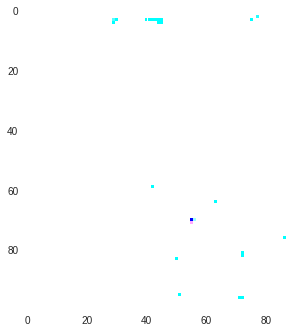

In [16]:
#print("TEST image shape: ",test_in[0].shape) 

# prediction

#unknown test data
#cv2.imshow("Original Img",test_original_resolution[0])
#cv2.imshow("Low resolution",test_imgs[0])
pred_image=model.predict(test_in[6:7])
'''cv2.imshow("Peredicted resolution",pred_image)
cv2.waitKey(0)
cv2.destroyAllWindows()'''


print("Peredicted resolution shape :",pred_image[0])

'''#save img
plt.subplot(221)
plt.imshow(test_in[2])

plt.subplot(222)
plt.imshow(test_out[2])

plt.subplot(223)
'''
plt.imshow(pred_image[0])



cv2.imwrite("Original_Img_colab.jpg",test_out[6])
cv2.imwrite("Input_resolution6_colab.jpg",test_in[6])
cv2.imwrite("Test_Output6_colab.jpg",pred_image[0])

In [0]:
'''for i in range(0,len(test_in)):
    cv2.imwrite("{0}.png".format(i),test_in[i])'''

In [11]:

#Save the model
model.save('resoluteitmodelCNN_colab.h5')
jsonmodel=model.to_json()
model.save_weights('savedWeightsCNN_colab.h5')


print(model.summary())

#loading saved weights
#modelWts=model.load_weights('savedWeightsCNN.h5')
#model.get_weights()
#model.get_config()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 100, 90, 64)       15616     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 90, 64)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 100, 90, 32)       2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 100, 90, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 90, 3)        2403      
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 90, 3)        0         
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________
None
